In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functions_NLM import estimate_nested_logit, simulate_choice

In [71]:
# Define log-likelihood function for telephone data
# beta will be beta = ["ASC_1", "ASC_3", "ASC_4", "ASC_5", "BETA_COST", "lambda_measured", "lambda_flat"]

def log_likelihood_telephone_NLM(beta, data):
    # Define utility functions
    data['U_1'] = beta[0] + beta[4] * data['logcost1'] 
    data['U_2'] = beta[4] * data['logcost2'] 
    data['U_3'] = beta[1] + beta[4] * data['logcost3']
    data['U_4'] = beta[2] + beta[4] * data['logcost4']
    data['U_5'] = beta[3] + beta[4] * data['logcost5']
    
    # Calculate logsum for nests with > 1 alt
    data['logsum_measured'] = np.log(data['avail1'] * np.exp(data['U_1'] / beta[5])
                                        + data['avail2'] * np.exp(data['U_2'] / beta[5])
                                        + (1 - data['avail1']) * (1 - data['avail2']))
    data['logsum_flat'] = np.log(data['avail3'] * np.exp(data['U_3'] / beta[6])
                                    + data['avail4'] * np.exp(data['U_4'] / beta[6])
                                    + data['avail5'] * np.exp(data['U_5'] / beta[6])
                                    + (1 - data['avail3']) * (1 - data['avail4']) * (1 - data['avail5']))
    
    # Nest probabilities
    data['P_nest_measured'] = np.exp(beta[5] * data['logsum_measured']) / \
                                 (np.exp(beta[5] * data['logsum_measured']) 
                                  + np.exp(beta[6] * data['logsum_flat']))
    data['P_nest_flat'] = 1 - data['P_nest_measured']
    
    # Within nest probabilities for nests with > 1 alt
    data['P_1_in_measured'] = data['avail1'] * np.exp(data['U_1'] / beta[5]) / \
                                (data['avail1'] * np.exp(data['U_1'] / beta[5]) 
                                 + data['avail2'] * np.exp(data['U_2'] / beta[5]))
    data['P_2_in_measured'] = 1 - data['P_1_in_measured']

    data['P_3_in_flat'] = data['avail3'] * np.exp(data['U_3'] / beta[6]) / \
                            (data['avail3'] * np.exp(data['U_3'] / beta[6])
                                + data['avail4'] * np.exp(data['U_4'] / beta[6])
                                + data['avail5'] * np.exp(data['U_5'] / beta[6]))
    data['P_4_in_flat'] = data['avail4'] * np.exp(data['U_4'] / beta[6]) / \
                            (data['avail3'] * np.exp(data['U_3'] / beta[6])
                                + data['avail4'] * np.exp(data['U_4'] / beta[6])
                                + data['avail5'] * np.exp(data['U_5'] / beta[6]))
    data['P_5_in_flat'] = 1 - data['P_3_in_flat'] - data['P_4_in_flat']
    
    # Full probabilities
    data['P_1'] = data['P_nest_measured'] * data['P_1_in_measured']
    data['P_2'] = data['P_nest_measured'] * data['P_2_in_measured']
    data['P_3'] = data['P_nest_flat'] * data['P_3_in_flat']
    data['P_4'] = data['P_nest_flat'] * data['P_4_in_flat']
    data['P_5'] = data['P_nest_flat'] * data['P_5_in_flat']
    
    # Calculate probability for chosen alternative for each row
    data['P'] = (data['choice'] == 1) * data['P_1'] + \
                (data['choice'] == 2) * data['P_2'] + \
                (data['choice'] == 3) * data['P_3'] + \
                (data['choice'] == 4) * data['P_4'] + \
                (data['choice'] == 5) * data['P_5']
    
    # Replace zero probabilities with small value to avoid LL = -inf
    epsilon = 1e-20
    data.loc[data['P'] == 0, 'P'] = epsilon
    
    # Calculate log-likelihood 
    LL = data['P'].apply(np.log).sum()
    
    return -LL  # We minimize negative log-likelihood

In [72]:
# Load data
data = pd.read_csv('./data/telephone.dat', sep='\t')

data['logcost1'] = np.log(data['cost1'])
data['logcost2'] = np.log(data['cost2'])
data['logcost3'] = np.log(data['cost3'])
data['logcost4'] = np.log(data['cost4'])
data['logcost5'] = np.log(data['cost5'])

# Define model parameters
beta = np.array([0, 0, 0, 0, 0, 1, 1])

beta_names = ["ASC_1", "ASC_3", "ASC_4", "ASC_5", "BETA_COST", "lambda_measured", "lambda_flat"]


In [73]:
# Estimate parameters
result, se, t_stat, p_value, aic, bic  = estimate_nested_logit(data, beta, beta_names, log_likelihood_telephone_NLM)

Optimization Results:
         Parameter  Estimate  Robust Asymptotic SE  t-statistic       p-value
0            ASC_1 -0.378246              0.125454    -3.015006  2.723024e-03
1            ASC_3  0.893446              0.171565     5.207627  2.980374e-07
2            ASC_4  0.847293              0.393757     2.151815  3.197195e-02
3            ASC_5  1.405502              0.259374     5.418828  1.004633e-07
4        BETA_COST -1.490024              0.252883    -5.892149  7.739943e-09
5  lambda_measured  0.484798              0.139705     3.470160  5.730726e-04
6      lambda_flat  0.436216              0.121307     3.595981  3.609402e-04
AIC: 960.4386663193137
BIC: 988.9499780580165


In [74]:
from functions_geom_DIB import geom_DIB_on_alternatives

In [75]:
np.random.seed(123)
data['simulated_choice'] = data.apply(simulate_choice, axis=1)

In [76]:
def multivariate_lognormal_pdf(x, mu, sigma):
    """
    Compute the probability density function (PDF) of a multivariate lognormal distribution.

    Parameters:
        x (ndarray): Vector in log space.
        mu (ndarray): Mean vector.
        sigma (ndarray): Covariance matrix.

    Returns:
        float: Value of the PDF at x.
    """
    n = len(x)
    
    # Compute the PDF of a multivariate normal distribution
    exponent = -0.5 * (x - mu).T @ np.linalg.inv(sigma) @ (x - mu)
    mvn_pdf = (1 / ((2 * np.pi) ** (n / 2) * np.sqrt(np.linalg.det(sigma)))) * np.exp(exponent)
    
    # Compute the Jacobian determinant term and remove x = 0 elements
    jacobian = np.prod(1 / x)

    pdf = jacobian * mvn_pdf

    # Compute the PDF of the multivariate lognormal distribution
    
    return pdf

---
---
---
---
---

<h2> Test different covariance matrices with NLM </h2>

In [77]:
# Function to calculate the number of elements in the largest cluster
def largest_cluster_size(q_t_given_x):
    # Calculate the size of each cluster
    cluster_sizes = np.sum(q_t_given_x, axis=0)
    # Find the size of the largest cluster
    largest_cluster_size = np.max(cluster_sizes)
    return largest_cluster_size

In [85]:
df_logcost = data[['logcost1', 'logcost2', 'logcost3', 'logcost4', 'logcost5']]
# Compute the mean vector and covariance matrix
log_df_logcost = np.log(df_logcost)
mean_vector = log_df_logcost.mean()

covariance_matrix = log_df_logcost.cov()

covariance_matrix_increased = covariance_matrix * 50

# Compute the probability density for each individual's cost vector
df_logcost['probability_density'] = df_logcost.apply(lambda row: multivariate_lognormal_pdf(row.values, mean_vector, covariance_matrix_increased), axis=1)

/var/folders/gk/16047hxn3hdgt8s5qmq_gnqh0000gp/T/ipykernel_1577/932657391.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_logcost['probability_density'] = df_logcost.apply(lambda row: multivariate_lognormal_pdf(row.values, mean_vector, covariance_matrix_increased), axis=1)


In [86]:
# Computation of p(x,y)
p_x = df_logcost['probability_density'].values

p_y_given_x = data[['P_1', 'P_2', 'P_3', 'P_4', 'P_5']].values
p_xy = p_x[:, np.newaxis] * p_y_given_x

# Normalize p_xy 
p_xy /= p_xy.sum()

# Define epsilon value
epsilon = 1e-20

# Add epsilon to elements equal to 0
p_xy[p_xy == 0] += epsilon

Iteration: 1 out of 5000
Iteration: 2 out of 5000
Iteration: 3 out of 5000
Iteration: 4 out of 5000
Iteration: 5 out of 5000
Iteration: 6 out of 5000
Iteration: 7 out of 5000
Iteration: 8 out of 5000
Iteration: 9 out of 5000
Iteration: 10 out of 5000
Iteration: 11 out of 5000
Iteration: 12 out of 5000
Iteration: 13 out of 5000
Iteration: 14 out of 5000
Iteration: 15 out of 5000
Iteration: 16 out of 5000
Iteration: 17 out of 5000
Iteration: 18 out of 5000
Iteration: 19 out of 5000
Iteration: 20 out of 5000
Iteration: 21 out of 5000
Iteration: 22 out of 5000
Iteration: 23 out of 5000
Iteration: 24 out of 5000
Iteration: 25 out of 5000
Iteration: 26 out of 5000
Iteration: 27 out of 5000
Iteration: 28 out of 5000
Iteration: 29 out of 5000
Iteration: 30 out of 5000
Iteration: 31 out of 5000
Iteration: 32 out of 5000
Iteration: 33 out of 5000
Iteration: 34 out of 5000
Iteration: 35 out of 5000
Iteration: 36 out of 5000
Iteration: 37 out of 5000
Iteration: 38 out of 5000
Iteration: 39 out of 

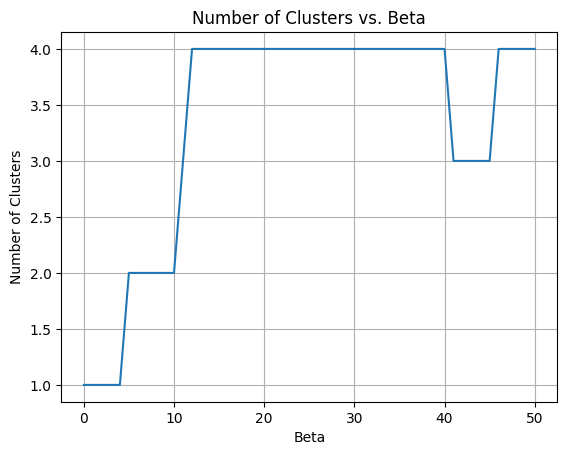

In [91]:
betas = np.linspace(0, 50, 51)
# Initialize an empty list to store the number of clusters
num_clusters_list = []
largest_cluster_sizes = []

# Iterate over each beta value
for beta in betas:
    # Run iterative_algorithm to obtain q_t_given_x
    q_t_given_x, _, _ = geom_DIB_on_alternatives(p_xy, max_iter=5000, beta=beta, threshold=1e-4)
    
    # Calculate the number of clusters
    column_sum = np.sum(q_t_given_x, axis=0)
    num_clusters = np.count_nonzero(column_sum)
    # Append the number of clusters to the list
    num_clusters_list.append(num_clusters)

        # Calculate the size of the largest cluster
    largest_size = largest_cluster_size(q_t_given_x)
    # Append the size of the largest cluster to the list
    largest_cluster_sizes.append(largest_size)

# Plot the number of clusters against beta values
plt.plot(betas, num_clusters_list)
plt.xlabel('Beta')
plt.ylabel('Number of Clusters')
plt.title('Number of Clusters vs. Beta')
plt.grid(True)
plt.show()

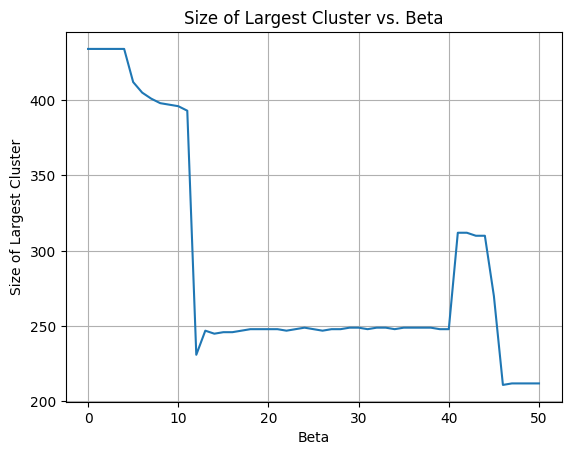

In [92]:
# Plot the number of elements in the largest cluster against beta values
plt.plot(betas, largest_cluster_sizes)
plt.xlabel('Beta')
plt.ylabel('Size of Largest Cluster')
plt.title('Size of Largest Cluster vs. Beta')
plt.grid(True)
plt.show()

In [118]:
q_t_given_x, q_t, q_y_given_t = geom_DIB_on_alternatives(p_xy, beta=45, max_iter=50000, threshold=1e-5)

Iteration: 1 out of 50000
Iteration: 2 out of 50000
Iteration: 3 out of 50000
Iteration: 4 out of 50000
Iteration: 5 out of 50000
Iteration: 6 out of 50000
Iteration: 7 out of 50000
Iteration: 8 out of 50000
Iteration: 9 out of 50000
Iteration: 10 out of 50000
Iteration: 11 out of 50000
Iteration: 12 out of 50000
Iteration: 13 out of 50000
Iteration: 14 out of 50000
Iteration: 15 out of 50000
Iteration: 16 out of 50000
Iteration: 17 out of 50000
Iteration: 18 out of 50000
Iteration: 19 out of 50000
Iteration: 20 out of 50000
Iteration: 21 out of 50000
Iteration: 22 out of 50000
Iteration: 23 out of 50000
Iteration: 24 out of 50000
Iteration: 25 out of 50000
Iteration: 26 out of 50000
Iteration: 27 out of 50000
Iteration: 28 out of 50000
Iteration: 29 out of 50000
Iteration: 30 out of 50000
Iteration: 31 out of 50000
Iteration: 32 out of 50000
Iteration: 33 out of 50000
Iteration: 34 out of 50000
Iteration: 35 out of 50000
Iteration: 36 out of 50000
Iteration: 37 out of 50000
Iteration:

In [119]:
# Calculate the number of clusters
column_sum = np.sum(q_t_given_x, axis=0)
num_clusters = np.count_nonzero(column_sum)
print('Number of clusters :', num_clusters)

# Count the number of observations in each cluster
data['cluster'] = np.argmax(q_t_given_x, axis=1)
print('\n', data['cluster'].value_counts())

# number of each alternative 1, 2, 3, 4, 5 in each cluster 
cluster_counts = data.groupby(['cluster', 'choice']).size().unstack(fill_value=0)
print('\n', cluster_counts)

data['max_proba'] = data[['P_1', 'P_2', 'P_3', 'P_4', 'P_5']].idxmax(axis=1).str[-1].astype(int)
cluster_counts2 = data.groupby(['cluster', 'max_proba']).size().unstack(fill_value=0)
print('\n', cluster_counts2)

cluster_counts3 = data.groupby(['cluster', 'simulated_choice']).size().unstack(fill_value=0)
print('\n', cluster_counts3)

Number of clusters : 3

 cluster
1    270
0    129
3     35
Name: count, dtype: int64

 choice    1   2    3  4   5
cluster                    
0        41  27   56  2   3
1        32  95  117  0  26
3         0   1    5  1  28

 max_proba   1   2    3  4   5
cluster                      
0          48   8   73  0   0
1           0  77  183  0  10
3           0   0    0  2  33

 simulated_choice   1   2    3  4   5
cluster                             
0                 41  39   46  0   3
1                 34  87  124  1  24
3                  0   2    3  1  29
